# AutoML 도입 - AutoGluon 경험해보기

이 노트북에서는 **AutoGluon**을 사용하여 AutoML(자동 머신러닝)을 경험해봅니다.

## 학습 목표
1. AutoGluon 라이브러리 설치 및 기본 사용법 익히기
2. TabularPredictor를 활용한 테이블 데이터 예측
3. Multi-target Regression (다중 타깃 회귀) 실습
4. AutoML의 장점과 한계 이해하기

## AutoGluon 특징
- **자동 피처 엔지니어링**: 범주형 변수 자동 인코딩
- **다양한 모델 앙상블**: LightGBM, XGBoost, Neural Network 등
- **Presets**: `best_quality`, `medium_quality_faster_train` 등 품질/속도 선택

## 사용 데이터
- 자율주행 관련 데이터셋 (Y_01 ~ Y_14 타깃)
- X features: 56개
- 각 타깃별 최소/최대 spec 정보 활용

## 실습 환경
- Google Colab
- Python 3.x

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,626 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
matplotlibrc 경로: /usr/local/lib/p

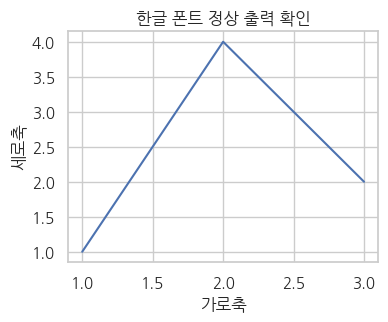

In [ ]:
# ==========================================
# 0. 한글 출력을 위한 기초 셀
#    (코랩에서 한 번만 실행하면 이후 그래프에 한글이 깨지지 않도록 설정)
#    참조: https://conding-note.tistory.com/335
# ==========================================

!apt-get update -qq
!apt-get install -y fonts-nanum

import matplotlib as mpl
print("matplotlibrc 경로:", mpl.matplotlib_fname())

import shutil
import matplotlib as mpl

# matplotlib 설정 파일(matplotlibrc)의 경로에서 루트 디렉토리만 추출
# 예) /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/matplotlibrc
#  → /usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/
root = mpl.matplotlib_fname().replace("matplotlibrc", "")

# matplotlib 기본 폰트 파일(DejaVuSans.ttf)이 위치한 경로
target_font = root + "fonts/ttf/DejaVuSans.ttf"
print("matplotlib 기본 폰트 파일:", target_font)

# 나눔고딕 폰트 경로 (Ubuntu/Colab에서 설치되는 경로)
nanum_font = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# shutil.copyfile:
# - 파일을 다른 경로로 복사하는 함수
# - 여기서는 DejaVuSans.ttf 파일을 나눔고딕으로 교체하여
#   matplotlib의 기본 폰트를 나눔고딕으로 바꿉니다.
shutil.copyfile(nanum_font, target_font)
print("기본 폰트를 나눔고딕으로 교체 완료")

# matplotlib 캐시 삭제
# - 캐시에 이전 폰트 정보가 남아 있으면 새 폰트가 바로 적용되지 않을 수 있어
#   캐시를 삭제하여 강제로 다시 로딩하도록 합니다.
!rm -rf ~/.cache/matplotlib

import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일을 'whitegrid'로 지정 (흰 배경 + 그리드)
sns.set(style="whitegrid")

# 테스트 플롯 (한글 출력 확인)
plt.figure(figsize=(4,3))
plt.title("한글 폰트 정상 출력 확인")
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.plot([1,2,3], [1,4,2])
plt.show()


In [ ]:
# ============================================================
# 0. 환경 설정 및 기본 로드
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

# 1) gdown 설치 (한 번만 실행)
!pip install -q gdown

# 2) 구글 드라이브에서 데이터 zip 파일 다운로드
#   - id 뒤에 있는 값이 링크의 파일 ID입니다.
#   - 필요하면 파일 이름(autonomous_driving.zip)만 바꿔서 쓰시면 됩니다.

FILE_ID = "10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA"
OUTPUT_ZIP = "autonomous_driving.zip"

!gdown --id {FILE_ID} -O {OUTPUT_ZIP}

# 3) 압축 해제
#   - autonomous_driving 폴더 아래에 내용을 풀어놓습니다.
#   - 압축이 zip이 아니라면 확장자에 맞게 unzip 대신 다른 명령을 쓰셔야 합니다.

!mkdir -p autonomous_driving
!unzip -q {OUTPUT_ZIP} -d autonomous_driving

# 잘 풀렸는지 확인
!ls -R autonomous_driving



/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10Hpa4YM0KX_Ig0W9w7DbTdq62nF2UThA
To: /content/autonomous_driving.zip
100% 10.0M/10.0M [00:00<00:00, 73.6MB/s]
autonomous_driving:
meta  sample_submission.csv  test.csv  train.csv

autonomous_driving/meta:
x_feature_info.csv  y_feature_info.csv	y_feature_spec_info.csv


In [ ]:
# ============================================================
# 1. AutoGluon 설치
# ============================================================

!pip install -q autogluon.tabular

from autogluon.tabular import TabularPredictor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.5 MB/s eta 0:00:00


In [ ]:
# ============================================================
# 2. 데이터 로드
# ============================================================

BASE_PATH = "/content/autonomous_driving"

train = pd.read_csv(f"{BASE_PATH}/train.csv")
test = pd.read_csv(f"{BASE_PATH}/test.csv")
sample_submission = pd.read_csv(f"{BASE_PATH}/sample_submission.csv")

y_spec = pd.read_csv(f"{BASE_PATH}/meta/y_feature_spec_info.csv")

# X, Y 지정
X_cols = [c for c in train.columns if c.startswith("X_")]
target_cols = [c for c in sample_submission.columns if c != "ID"]

# y_spec 최소·최대
spec_min = dict(zip(y_spec["Feature"], y_spec["최소"]))
spec_max = dict(zip(y_spec["Feature"], y_spec["최대"]))

In [ ]:
# ============================================================
# 3. 기본 설정 (피처 / 타깃 정의)
# ============================================================

# X feature 컬럼: X_로 시작하는 컬럼 전부
X_cols = [c for c in train.columns if c.startswith("X_")]

# 타깃 컬럼: sample_submission의 ID를 제외한 나머지 (Y_01 ~ Y_14)
target_cols = [c for c in sample_submission.columns if c != "ID"]

print("X_cols (개수):", len(X_cols))
print("target_cols:", target_cols)

# y_spec에서 각 타깃별 최소/최대 dict 생성 (클리핑용)
spec_min = dict(zip(y_spec["Feature"], y_spec["최소"]))
spec_max = dict(zip(y_spec["Feature"], y_spec["최대"]))

print("예시 spec_min:", {k: spec_min[k] for k in target_cols[:3]})
print("예시 spec_max:", {k: spec_max[k] for k in target_cols[:3]})

X_cols (개수): 56
target_cols: ['Y_01', 'Y_02', 'Y_03', 'Y_04', 'Y_05', 'Y_06', 'Y_07', 'Y_08', 'Y_09', 'Y_10', 'Y_11', 'Y_12', 'Y_13', 'Y_14']
예시 spec_min: {'Y_01': 0.2, 'Y_02': 0.2, 'Y_03': 0.2}
예시 spec_max: {'Y_01': 2.0, 'Y_02': 2.1, 'Y_03': 2.1}


In [ ]:
# ============================================================
# 3. Full AutoML: AutoGluon Best Quality + Ensemble/Stacking
# ============================================================

MODEL_ROOT = f"{BASE_PATH}/Autogluon_Full"

# 결과 저장
test_pred_df = pd.DataFrame({"ID": test["ID"]})

for target in target_cols:
    print("=" * 70)
    print(f"[FULL AutoML] Running Best Quality AutoML for {target}")
    print("=" * 70)

    # 타깃별 데이터 구성 (ID 제거, X + 해당 Y만 사용)
    df_target = train[["ID"] + X_cols + [target]].drop(columns=["ID"])

    # FULL AutoML 설정
    predictor = TabularPredictor(
        label=target,
        path=f"{MODEL_ROOT}/{target}",
        eval_metric="root_mean_squared_error",
    )

    predictor.fit(
        train_data=df_target,
        presets="best_quality",
        time_limit=300,        # 타깃당 300초 (원하면 더 늘려서 성능↑)
        dynamic_stacking=False,
        verbosity=2,
    )

    # Rank / Ensemble 등 포함 전체 모델 리스트
    print(predictor.leaderboard(silent=True))

    # 테스트 추론
    test_X = test[X_cols].copy()
    pred = predictor.predict(test_X)

    # spec min/max 적용
    pred = pred.clip(spec_min[target], spec_max[target])

    test_pred_df[target] = pred

Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.85 GB / 12.67 GB (85.6%)
Disk Space Avail:   65.92 GB / 112.64 GB (58.5%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_01


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_01"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_01
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (4.409, 0.017, 1.35381, 0.35622)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11129.14 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually sp

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.352814  root_mean_squared_error       0.370481   
1           LightGBMXT  -0.353006  root_mean_squared_error       0.051995   
2             LightGBM  -0.354138  root_mean_squared_error       0.013149   
3      RandomForestMSE  -0.354314  root_mean_squared_error       0.318036   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  397.087710                0.000451           0.007149            2   
1    3.186889                0.051995           3.186889            1   
2    2.122100                0.013149           2.122100            1   
3  393.893672                0.318036         393.893672            1   

   can_infer  fit_order  
0       True          4  
1       True          1  
2       True          2  
3       True          3  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.84 GB / 12.67 GB (85.5%)
Disk Space Avail:   65.31 GB / 112.64 GB (58.0%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_02


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_02"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_02
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3.998, 0.007, 1.05727, 0.38627)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11114.52 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually sp

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.382360  root_mean_squared_error       0.359638   
1      RandomForestMSE  -0.382676  root_mean_squared_error       0.324543   
2           LightGBMXT  -0.383446  root_mean_squared_error       0.022727   
3             LightGBM  -0.383656  root_mean_squared_error       0.012005   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  399.261153                0.000363           0.007108            2   
1  395.017214                0.324543         395.017214            1   
2    2.268379                0.022727           2.268379            1   
3    1.968452                0.012005           1.968452            1   

   can_infer  fit_order  
0       True          4  
1       True          3  
2       True          1  
3       True          2  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.77 GB / 12.67 GB (85.0%)
Disk Space Avail:   64.71 GB / 112.64 GB (57.4%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_03


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_03"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_03
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3.756, 0.017, 1.014, 0.36149)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11048.54 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually spec

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.360489  root_mean_squared_error       0.344943   
1      RandomForestMSE  -0.360948  root_mean_squared_error       0.309721   
2           LightGBMXT  -0.361397  root_mean_squared_error       0.026056   
3             LightGBM  -0.361673  root_mean_squared_error       0.008769   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  394.984637                0.000398           0.007361            2   
1  390.109634                0.309721         390.109634            1   
2    2.424071                0.026056           2.424071            1   
3    2.443571                0.008769           2.443571            1   

   can_infer  fit_order  
0       True          4  
1       True          3  
2       True          1  
3       True          2  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.83 GB / 12.67 GB (85.5%)
Disk Space Avail:   64.10 GB / 112.64 GB (56.9%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_04


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_04"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_04
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (98.794, -0.331, 13.62119, 2.68663)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11107.47 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually

[1000]	valid_set's rmse: 2.60857


	-2.6065	 = Validation score   (-root_mean_squared_error)
	9.11s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 65.37s of the 65.37s of remaining time.
	Fitting with cpus=1, gpus=0, mem=0.1/10.8 GB


[1000]	valid_set's rmse: 2.61992


	-2.6168	 = Validation score   (-root_mean_squared_error)
	8.33s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 56.81s of the 56.81s of remaining time.
	Fitting with cpus=2, gpus=0, mem=0.0/10.8 GB
	-2.6086	 = Validation score   (-root_mean_squared_error)
	404.29s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 74.76s of the -386.79s of remaining time.
	Ensemble Weights: {'RandomForestMSE': 0.409, 'LightGBMXT': 0.364, 'LightGBM': 0.227}
	-2.5947	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 461.86s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 4240.3 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/autonomous_driving/Autogluon_Full/Y_04")


                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -2.594706  root_mean_squared_error       0.589576   
1           LightGBMXT  -2.606472  root_mean_squared_error       0.159016   
2      RandomForestMSE  -2.608607  root_mean_squared_error       0.304393   
3             LightGBM  -2.616842  root_mean_squared_error       0.125685   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  421.750085                0.000483           0.013398            2   
1    9.113374                0.159016           9.113374            1   
2  404.293136                0.304393         404.293136            1   
3    8.330177                0.125685           8.330177            1   

   can_infer  fit_order  
0       True          4  
1       True          1  
2       True          3  
3       True          2  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.81 GB / 12.67 GB (85.3%)
Disk Space Avail:   63.49 GB / 112.64 GB (56.4%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_05


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_05"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_05
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (37.25, 18.589, 31.29047, 2.54322)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11086.54 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually 

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -2.508141  root_mean_squared_error       0.462295   
1           LightGBMXT  -2.509992  root_mean_squared_error       0.067295   
2             LightGBM  -2.514931  root_mean_squared_error       0.020428   
3      RandomForestMSE  -2.523267  root_mean_squared_error       0.374046   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  439.554335                0.000525           0.016737            2   
1    3.719975                0.067295           3.719975            1   
2    2.581817                0.020428           2.581817            1   
3  433.235806                0.374046         433.235806            1   

   can_infer  fit_order  
0       True          4  
1       True          1  
2       True          2  
3       True          3  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.80 GB / 12.67 GB (85.3%)
Disk Space Avail:   62.89 GB / 112.64 GB (55.8%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_06


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_06"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_06
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (18.998, -19.963, 16.52938, 1.89301)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11086.01 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manuall

[1000]	valid_set's rmse: 2.21202
[2000]	valid_set's rmse: 2.20202


	-2.2	 = Validation score   (-root_mean_squared_error)
	12.09s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 62.28s of the 62.28s of remaining time.
	Fitting with cpus=1, gpus=0, mem=0.1/10.8 GB
	-2.1561	 = Validation score   (-root_mean_squared_error)
	4.1s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 58.09s of the 58.09s of remaining time.
	Fitting with cpus=2, gpus=0, mem=0.0/10.8 GB
	-2.2504	 = Validation score   (-root_mean_squared_error)
	473.39s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 74.77s of the -428.77s of remaining time.
	Ensemble Weights: {'LightGBM': 0.96, 'LightGBMXT': 0.04}
	-2.1561	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 503.84s ... Best model: WeightedEnsemble_L2 

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -2.156094  root_mean_squared_error       0.258384   
1             LightGBM  -2.156133  root_mean_squared_error       0.039498   
2           LightGBMXT  -2.199963  root_mean_squared_error       0.218541   
3      RandomForestMSE  -2.250411  root_mean_squared_error       0.318135   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0   16.197848                0.000345           0.007009            2   
1    4.103916                0.039498           4.103916            1   
2   12.086923                0.218541          12.086923            1   
3  473.389089                0.318135         473.389089            1   

   can_infer  fit_order  
0       True          4  
1       True          2  
2       True          1  
3       True          3  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.85 GB / 12.67 GB (85.6%)
Disk Space Avail:   62.28 GB / 112.64 GB (55.3%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_07


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_07"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_07
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5.299, 0.502, 3.15505, 0.41894)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11127.80 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually sp

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.416119  root_mean_squared_error       0.645487   
1             LightGBM  -0.416989  root_mean_squared_error       0.043071   
2           LightGBMXT  -0.417799  root_mean_squared_error       0.061880   
3      RandomForestMSE  -0.418086  root_mean_squared_error       0.540041   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  425.414660                0.000495           0.007882            2   
1    4.818474                0.043071           4.818474            1   
2    6.000837                0.061880           6.000837            1   
3  414.587467                0.540041         414.587467            1   

   can_infer  fit_order  
0       True          4  
1       True          2  
2       True          1  
3       True          3  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.85 GB / 12.67 GB (85.6%)
Disk Space Avail:   61.67 GB / 112.64 GB (54.8%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_08


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_08"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_08
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (-23.785, -29.652, -26.29484, 0.66054)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11129.55 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manua

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.640174  root_mean_squared_error       0.336310   
1      RandomForestMSE  -0.640868  root_mean_squared_error       0.309373   
2             LightGBM  -0.643661  root_mean_squared_error       0.026596   
3           LightGBMXT  -0.645887  root_mean_squared_error       0.076383   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  416.664715                0.000341           0.006924            2   
1  413.393259                0.309373         413.393259            1   
2    3.264532                0.026596           3.264532            1   
3    5.348052                0.076383           5.348052            1   

   can_infer  fit_order  
0       True          4  
1       True          3  
2       True          2  
3       True          1  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.82 GB / 12.67 GB (85.4%)
Disk Space Avail:   61.06 GB / 112.64 GB (54.2%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_09


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_09"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_09
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (-23.96, -29.523, -26.30862, 0.65358)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11103.31 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manual

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.638795  root_mean_squared_error       0.342006   
1      RandomForestMSE  -0.639556  root_mean_squared_error       0.304865   
2             LightGBM  -0.643161  root_mean_squared_error       0.036704   
3           LightGBMXT  -0.644439  root_mean_squared_error       0.077878   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  414.125468                0.000437           0.009432            2   
1  409.732295                0.304865         409.732295            1   
2    4.383742                0.036704           4.383742            1   
3    4.055288                0.077878           4.055288            1   

   can_infer  fit_order  
0       True          4  
1       True          3  
2       True          2  
3       True          1  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.82 GB / 12.67 GB (85.4%)
Disk Space Avail:   60.46 GB / 112.64 GB (53.7%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_10


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_10"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_10
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (-20.052, -31.119, -22.40006, 0.92095)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11102.42 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manua

[1000]	valid_set's rmse: 0.925846
[2000]	valid_set's rmse: 0.924569


	-0.9237	 = Validation score   (-root_mean_squared_error)
	15.44s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 58.77s of the 58.77s of remaining time.
	Fitting with cpus=1, gpus=0, mem=0.1/10.8 GB
	-0.9095	 = Validation score   (-root_mean_squared_error)
	5.23s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 53.44s of the 53.44s of remaining time.
	Fitting with cpus=2, gpus=0, mem=0.0/10.8 GB
	-0.9211	 = Validation score   (-root_mean_squared_error)
	412.44s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 74.74s of the -367.08s of remaining time.
	Ensemble Weights: {'LightGBM': 0.792, 'RandomForestMSE': 0.125, 'LightGBMXT': 0.083}
	-0.9091	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 442.15s ... 

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.909071  root_mean_squared_error       0.654251   
1             LightGBM  -0.909485  root_mean_squared_error       0.042009   
2      RandomForestMSE  -0.921108  root_mean_squared_error       0.305050   
3           LightGBMXT  -0.923692  root_mean_squared_error       0.306829   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  433.113649                0.000362           0.006954            2   
1    5.230775                0.042009           5.230775            1   
2  412.440796                0.305050         412.440796            1   
3   15.435124                0.306829          15.435124            1   

   can_infer  fit_order  
0       True          4  
1       True          2  
2       True          3  
3       True          1  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.83 GB / 12.67 GB (85.5%)
Disk Space Avail:   59.84 GB / 112.64 GB (53.1%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_11


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_11"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_11
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (26.703, 19.844, 24.32506, 0.8302)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11100.21 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually 

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.832702  root_mean_squared_error       0.396882   
1             LightGBM  -0.834539  root_mean_squared_error       0.027861   
2           LightGBMXT  -0.834626  root_mean_squared_error       0.053039   
3      RandomForestMSE  -0.836941  root_mean_squared_error       0.315641   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  442.718341                0.000340           0.007228            2   
1    3.375629                0.027861           3.375629            1   
2    5.069798                0.053039           5.069798            1   
3  434.265686                0.315641         434.265686            1   

   can_infer  fit_order  
0       True          4  
1       True          2  
2       True          1  
3       True          3  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.82 GB / 12.67 GB (85.4%)
Disk Space Avail:   59.24 GB / 112.64 GB (52.6%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_12


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_12"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_12
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (-23.722, -29.544, -26.23776, 0.65633)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11101.34 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manua

[1000]	valid_set's rmse: 0.641582


	-0.6415	 = Validation score   (-root_mean_squared_error)
	8.18s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 66.27s of the 66.27s of remaining time.
	Fitting with cpus=1, gpus=0, mem=0.1/10.8 GB


[1000]	valid_set's rmse: 0.639965


	-0.6392	 = Validation score   (-root_mean_squared_error)
	7.17s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 58.76s of the 58.76s of remaining time.
	Fitting with cpus=2, gpus=0, mem=0.0/10.8 GB
	-0.6408	 = Validation score   (-root_mean_squared_error)
	423.89s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 74.70s of the -408.90s of remaining time.
	Ensemble Weights: {'LightGBM': 0.5, 'RandomForestMSE': 0.357, 'LightGBMXT': 0.143}
	-0.6371	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 483.97s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 4064.7 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/autonomous_driving/Autogluon_Full/Y_12")


                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.637081  root_mean_squared_error       0.615051   
1             LightGBM  -0.639243  root_mean_squared_error       0.156700   
2      RandomForestMSE  -0.640819  root_mean_squared_error       0.312625   
3           LightGBMXT  -0.641537  root_mean_squared_error       0.145287   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  439.241251                0.000438           0.006988            2   
1    7.167267                0.156700           7.167267            1   
2  423.890227                0.312625         423.890227            1   
3    8.176769                0.145287           8.176769            1   

   can_infer  fit_order  
0       True          4  
1       True          2  
2       True          3  
3       True          1  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.81 GB / 12.67 GB (85.3%)
Disk Space Avail:   58.63 GB / 112.64 GB (52.1%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_13


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_13"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_13
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (-23.899, -29.448, -26.23387, 0.65509)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11109.53 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manua

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.640473  root_mean_squared_error       0.363112   
1      RandomForestMSE  -0.640858  root_mean_squared_error       0.330220   
2             LightGBM  -0.645058  root_mean_squared_error       0.032512   
3           LightGBMXT  -0.645978  root_mean_squared_error       0.052876   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  425.608009                0.000380           0.007964            2   
1  421.049791                0.330220         421.049791            1   
2    4.550253                0.032512           4.550253            1   
3    3.928157                0.052876           3.928157            1   

   can_infer  fit_order  
0       True          4  
1       True          3  
2       True          2  
3       True          1  


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Oct  2 10:42:05 UTC 2025
CPU Count:          2
Memory Avail:       10.82 GB / 12.67 GB (85.4%)
Disk Space Avail:   58.02 GB / 112.64 GB (51.5%)
Presets specified: ['medium_quality_faster_train']
Using hyperparameters preset: hyperparameters='default'


[FULL AutoML] Running Best Quality AutoML for Y_14


Beginning AutoGluon training ... Time limit = 75s
AutoGluon will save models to "/content/autonomous_driving/Autogluon_Full/Y_14"
Train Data Rows:    39607
Train Data Columns: 56
Label Column:       Y_14
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (-23.856, -29.62, -26.24587, 0.65599)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11122.07 MB
	Train Data (Original)  Memory Usage: 16.92 MB (0.2% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manual

                 model  score_val              eval_metric  pred_time_val  \
0  WeightedEnsemble_L2  -0.637878  root_mean_squared_error       0.363703   
1      RandomForestMSE  -0.639629  root_mean_squared_error       0.322094   
2             LightGBM  -0.640033  root_mean_squared_error       0.041187   
3           LightGBMXT  -0.642097  root_mean_squared_error       0.035200   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  416.055759                0.000422           0.008759            2   
1  411.891634                0.322094         411.891634            1   
2    4.155366                0.041187           4.155366            1   
3    3.624561                0.035200           3.624561            1   

   can_infer  fit_order  
0       True          4  
1       True          3  
2       True          2  
3       True          1  


In [ ]:
# ============================================================
# 4. 제출 파일 생성
# ============================================================

submission = sample_submission.copy()
for target in target_cols:
    submission[target] = test_pred_df[target]

SAVE_PATH = f"{BASE_PATH}/submission_full_automl.csv"
submission.to_csv(SAVE_PATH, index=False)
print("저장 완료:", SAVE_PATH)

submission.head()

저장 완료: /content/autonomous_driving/submission_full_automl.csv


,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,1.439908,1.236950,1.162477,14.398384,31.193666,16.900709,3.092302,-26.101877,-26.115559,-22.182226,24.515551,-25.953695,-26.054943,-26.003893
1,TEST_00002,1.468054,1.237716,1.149987,13.354094,30.929266,16.676746,3.192359,-26.279535,-26.204777,-22.283594,24.381147,-26.140133,-26.146376,-26.126022
2,TEST_00003,1.433068,1.150542,1.093521,14.753347,32.294514,16.803112,3.089966,-26.025328,-25.969843,-22.274431,24.396717,-25.969030,-25.931866,-25.965626
3,TEST_00004,1.456332,1.131239,1.019629,15.027258,32.429302,16.919838,3.105817,-25.742821,-25.776024,-21.763435,24.826448,-25.659613,-25.650757,-25.701033
4,TEST_00005,1.343061,1.037863,0.983201,15.131520,31.608019,16.769739,3.082567,-25.705357,-25.652958,-21.947803,24.855724,-25.599371,-25.611864,-25.651512
